## Modality-specific decoding
Population decoding of the object identity and modality condition based on support vector machine.
The purpose of this analysis is to see how much decoding performance improves when temporal information is added sequentially.

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

from joblib import Parallel, delayed

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
mother_path = Path('D:/Multi-modal project/')

save_path = mother_path / 'analysis' / 'result2' / '7. Population decoding'
os.makedirs(save_path,exist_ok=True)

fig_path = mother_path / 'analysis' / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [5]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [6]:
cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Jun-2023'
cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result2'/'3.1 Multiple linear regression'/'2023-12-20 (interaction)'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-12-20_multiple_regression_result.hdf5','r')

In [7]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [8]:
df = h5_to_df(f)
df = df[df['region']=='PER']
df.reset_index(inplace=True, drop=True)

for key in df['key']:
    if df.loc[df['key']==key, 'object cell'].item() == 0:
        df.loc[df['key']==key, 'category'] = 'none'
    else:
        if f2[key].attrs['response cell'] == 0:
            df.loc[df['key']==key, 'category'] = 'object'
        else:
            df.loc[df['key']==key, 'category'] = 'response'

### Check the number of neurons available for population analysis

In [10]:
rat_list = np.sort(df['rat'].unique())
print(rat_list)

['600' '602' '640' '647' '654' '679' '699']


In [11]:
# none cell + object cell (response cell excluded)
cell_array = np.zeros((len(rat_list),int(df['session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'session'])
    
    if df.loc[i,'category'] != 'response':
        cell_array[rat_id, ss-1] += 1

print('===== Object cells + None =====')        
print(cell_array)

===== Object cells + None =====
[[ 9. 11.  5. 11.  7.  0.  0.]
 [26. 19. 28. 16. 16.  0.  0.]
 [11. 14.  9.  5.  4.  0.  0.]
 [ 0.  0.  0. 14. 10.  8.  4.]
 [ 7.  4.  0.  0.  1.  0.  0.]
 [ 0.  2.  2.  3.  0.  1.  0.]
 [ 9.  9. 16. 15. 17.  7.  0.]]


In [12]:
# only object cell (response cell, none cell excluded)
cell_array = np.zeros((len(rat_list),int(df['session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'session'])
    
    if df.loc[i,'category'] == 'object':
        cell_array[rat_id, ss-1] += 1

print('====== Only object cells ======')
print(cell_array)

====== Only object cells ======
[[ 6.  6.  4.  4.  5.  0.  0.]
 [15.  6. 10.  5.  8.  0.  0.]
 [ 8. 10.  4.  4.  2.  0.  0.]
 [ 0.  0.  0.  9.  4.  4.  4.]
 [ 3.  2.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  0.]
 [ 4.  3.  6.  3.  8.  3.  0.]]


In [13]:
num_obj = np.sum(cell_array,axis=1)
print('# of object cells in each rat')
print('-----------------------------')
for i in range(len(rat_list)):
    print(f'LE{rat_list[i]}: {int(num_obj[i])}')

# of object cells in each rat
-----------------------------
LE600: 25
LE602: 44
LE640: 28
LE647: 21
LE654: 6
LE679: 2
LE699: 27


In [ ]:
# visual / auditory / unbiased cell
visual_array = np.zeros((len(rat_list),int(df['session'].max())))
auditory_array = np.zeros((len(rat_list),int(df['session'].max())))
unbiased_array = np.zeros((len(rat_list),int(df['session'].max())))

for i in range(len(df2)):
    rat = str(df2.loc[i, 'rat'])
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df2.loc[i, 'session'])

    if df2.loc[i,'Category'] == 'visual':
        visual_array[rat_id, ss-1] += 1
    elif df2.loc[i,'Category'] == 'auditory':
        auditory_array[rat_id, ss-1] += 1
    elif df2.loc[i,'Category'] == 'unbiased':
        unbiased_array[rat_id, ss-1] += 1        

num_visual = np.sum(visual_array,axis=1)
num_auditory = np.sum(auditory_array,axis=1)
num_unbiased = np.sum(unbiased_array,axis=1)
print('# of visual / auditory / unbiased cells in each rat')
print('---------------------------------------------------')
for i in range(len(rat_list)):
    print(f'LE{rat_list[i]}: {int(num_visual[i])} / {int(num_auditory[i])} / {int(num_unbiased[i])}')

---

## Population decoding

In [15]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Object * modality decoding using all object cells
Object and modality conditions (2 by 3) were classified using linear support vector machine.
All object cells are used in this analysis.
We verified if the decoding performance increased as the temporal information is gradually added.

In [16]:
def subsample(df, rat, num_trial, bin_size, time_bin, shuffle):
    scaler = StandardScaler()

    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()

    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))

    for i,cell_key in enumerate(object_cell_list):

        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)

        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub
    
    X_norm = scaler.fit_transform(X)

    return X_norm

In [17]:
def subsample_cross_val_predict(df, model, rat, kfold, num_trial, bin_size, time_bin, shuffle):
    result = np.zeros((6,6))

    X = subsample(df, rat, num_trial, bin_size, time_bin, shuffle)
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        pred = model.predict(X[test_index,:])
        for j in range(6):
            result[j,pred[j]] += 1

    return result

#### SVM parameter

In [18]:
final_model = svm.SVC(kernel='linear', C=0.01)
kfold = 5
num_trial = 5
bin_size = 10
num_iter = 100
rat_list = ['600', '602', '640', '647', '699']

#### Real data

In [19]:
%%time
for t in range(9):
    bin_loop_start = time.time()

    svm_real = np.zeros((len(rat_list),6,6))
    for i,rat in enumerate(rat_list):
        loop_start = time.time()

        rat_result = Parallel(n_jobs=-1)(delayed(subsample_cross_val_predict)(df, final_model, rat, kfold, num_trial, bin_size, t+1, 0) for j in range(num_iter))   

        svm_real[i,:,:] = np.sum(rat_result,axis=0)/(num_iter*kfold)

        loop_end = time.time()
        loop_time = divmod(loop_end-loop_start,60)
        print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_real.npy',svm_real)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

LE600 completed /// Elapsed time: 0 min 14.34 sec
LE602 completed /// Elapsed time: 0 min 19.07 sec
LE640 completed /// Elapsed time: 0 min 13.37 sec
LE647 completed /// Elapsed time: 0 min 10.55 sec
LE699 completed /// Elapsed time: 0 min 12.23 sec
---------------------------------------------------
1 timebin completed / Elapsed time: 1 min 9.57 sec

LE600 completed /// Elapsed time: 0 min 10.91 sec
LE602 completed /// Elapsed time: 0 min 19.31 sec
LE640 completed /// Elapsed time: 0 min 13.37 sec
LE647 completed /// Elapsed time: 0 min 10.50 sec
LE699 completed /// Elapsed time: 0 min 12.26 sec
---------------------------------------------------
2 timebin completed / Elapsed time: 1 min 6.35 sec

LE600 completed /// Elapsed time: 0 min 11.35 sec
LE602 completed /// Elapsed time: 0 min 19.44 sec
LE640 completed /// Elapsed time: 0 min 13.65 sec
LE647 completed /// Elapsed time: 0 min 10.60 sec
LE699 completed /// Elapsed time: 0 min 12.27 sec
------------------------------------------

#### Shuffled data

In [ ]:
%%time
num_shuffle = 1000

for t in range(9):
    bin_loop_start = time.time()
    
    svm_shuffle_result = np.zeros((num_shuffle,len(rat_list),6,6))
    for shuffle_run in range(num_shuffle):
        
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 1:
            loop_start = time.time()
            
        svm_result = np.zeros((len(rat_list),6,6))
        for r,rat in enumerate(rat_list):
            rat_result = Parallel(n_jobs=-1)(delayed(subsample_cross_val_predict)(df, final_model, rat, kfold, num_trial, bin_size, t+1, 1) for j in range(num_iter))   
            svm_result[r,:,:] = np.sum(rat_result,axis=0)/(num_iter*kfold*2)

        svm_shuffle_result[shuffle_run,:,:,:] = svm_result
    
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 0:
            loop_end = time.time()
            loop_time = divmod(loop_end-loop_start,60)
            print(f'Shuffle run {shuffle_run+1} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_shuffle.npy',svm_shuffle_result)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

#### Evaluating decoding results

In [21]:
save_path

WindowsPath('D:/Multi-modal project/analysis/result2/7. Population decoding')

In [23]:
load_date = '2023-12-22'
np_path = save_path / 'all conditions'

real_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_real.npy')
#shuffle_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_shuffle.npy')

real_mean = np.mean(real_data, axis=0)/6
#shuffle_mean = np.mean(shuffle_data, axis=1)/3

In [ ]:
# distributions of shuffled decoding performance
fig,ax = plt.subplots(6,6, figsize=(15,12))
for i in range(6):
    for j in range(6):
        m = np.round(np.mean(shuffle_mean[:,i,j]*100))/100
        ax[i,j].hist(shuffle_mean[:,i,j], color='gray');
plt.tight_layout()

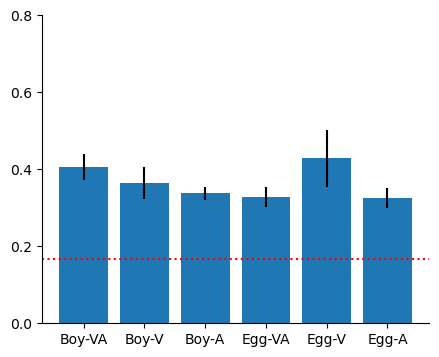

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,condition,0.046900,5,0.009380,1.363255,0.279669,0.189151,0.36352
1,Error,0.137611,20,0.006881,NaN,NaN,NaN,NaN


In [24]:
# decoding accuracy for each condition (bar plot)
accuracy = np.zeros((5,6))

for i in range(5):
    for j in range(6):
        acc = real_data[i,j,j]/np.sum(real_data[i,j,:])
        accuracy[i,j] = acc

acc_mean = np.mean(accuracy, axis=0)
acc_sem = stats.sem(accuracy, axis=0)

x = ['Boy-VA', 'Boy-V', 'Boy-A', 'Egg-VA', 'Egg-V', 'Egg-A']

fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(x=x, y = acc_mean, yerr = acc_sem, fmt='none', color='black')
ax.bar(x=x, height = acc_mean)
ax.axhline(y = 0.166, linestyle=':', color='red')
ax.set_yticks(np.arange(0,0.9,0.2))
ax.set_ylim([0,0.8])

plt.savefig(fig_path / 'svg' / 'decoding_accuracy_bar.svg')
plt.show()

df_acc = pd.DataFrame(accuracy)
df_acc = df_acc.melt(var_name='condition', value_name='value')
df_acc['subject'] = df_acc.index % 5
pg.rm_anova(data = df_acc, dv = 'value', within = 'condition', subject = 'subject', detailed=True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31980\2261109716.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(real_mean, cmap=plt.cm.get_cmap('Blues'));


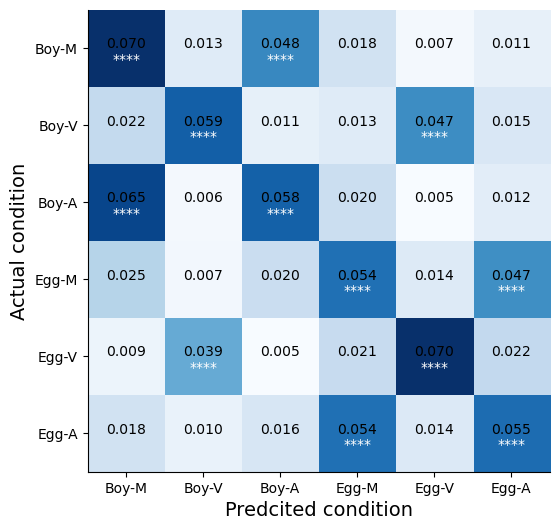

In [16]:
# contingency matrix for data using all time bins
fig,ax = plt.subplots(figsize=(6,6))
#cax = fig.add_axes([0,0.3,0.05,0.5])

im = ax.imshow(real_mean, cmap=plt.cm.get_cmap('Blues'));
ax.set_xlabel('Predcited condition', fontsize=14)
ax.set_ylabel('Actual condition', fontsize=14)

for m in range(6):
    for l in range(6):        
        ax.text(m,l,'{:.3f}'.format(real_mean[l,m]),ha='center')
        
        pval_crit = [np.percentile(shuffle_mean[:,m,l],95), np.percentile(shuffle_mean[:,m,l],99),
                     np.percentile(shuffle_mean[:,m,l],99.9), np.percentile(shuffle_mean[:,m,l],99.99)]
        if real_mean[l,m] > pval_crit[3]:
            ax.text(m,l+0.2,'****', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[2]:
            ax.text(m,l+0.2,'***', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[1]:
            ax.text(m,l+0.2,'**', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[0]:
            ax.text(m,l+0.2,'*', ha='center', color='white')

ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);
ax.set_yticks(np.arange(0,6))
ax.set_yticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);

#fig.colorbar(im, cax = cax, orientation='vertical')
#plt.savefig(fig_path / 'svg' / 'confusion_all_conditions.svg')
#plt.tight_layout()

In [ ]:
# contingency matrix for data using all time bins
fig,ax = plt.subplots(figsize=(6,6))
#cax = fig.add_axes([0,0.3,0.05,0.5])

im = ax.imshow(real_mean, cmap=plt.cm.get_cmap('Blues'));
ax.set_xlabel('Predcited condition', fontsize=14)
ax.set_ylabel('Actual condition', fontsize=14)

for m in range(6):
    for l in range(6):        
        ax.text(m,l,'{:.3f}'.format(real_mean[l,m]),ha='center')
        
        pval_crit = [np.percentile(shuffle_mean[:,m,l],95), np.percentile(shuffle_mean[:,m,l],99),
                     np.percentile(shuffle_mean[:,m,l],99.9), np.percentile(shuffle_mean[:,m,l],99.99)]
        if real_mean[l,m] > pval_crit[3]:
            ax.text(m,l+0.2,'****', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[2]:
            ax.text(m,l+0.2,'***', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[1]:
            ax.text(m,l+0.2,'**', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[0]:
            ax.text(m,l+0.2,'*', ha='center', color='white')

ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);
ax.set_yticks(np.arange(0,6))
ax.set_yticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);

#fig.colorbar(im, cax = cax, orientation='vertical')
#plt.savefig(fig_path / 'svg' / 'confusion_all_conditions.svg')
#plt.tight_layout()

In [ ]:
# decoding performance of models using different time range

result = np.zeros((3,5,9))    # modality * rat * timebin
result_shuffle = np.zeros((3,5,9))    # modality * rat * timebin

for t in range(9):
    real_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_real.npy')
    shuffle_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_shuffle.npy')
    shuffle_mean = np.mean(shuffle_data, axis=0)
    
    for i in range(3):
        result[i,:,t] = (real_data[:,i,i]+real_data[:,i+3,i+3])/6
        result_shuffle[i,:,t] = (shuffle_mean[:,i,i]+shuffle_mean[:,i+3,i+3])/3

mean_real = np.mean(result, axis=1)
sem_real = stats.sem(result, axis=1)
mean_shuffle = np.mean(result_shuffle, axis=1)

fig,ax = plt.subplots(figsize=(6,4))

for i in range(3):
    ax.errorbar(range(9),mean_real[i],yerr=sem_real[i], color=color[i], linewidth=3)
    ax.plot(mean_shuffle[i], color=color[i], linestyle='--', linewidth=2)

ax.set_xticks(range(9));
ax.set_xticklabels(['~0.1s', '~0.2s', '~0.3s', '~0.4s', '~0.5s', '~0.6s', '~0.7s', '~0.8s', '~0.9s']);
ax.set_yticks(np.arange(0.04,0.18,0.02));
ax.set_ylim([0.04,0.16])
ax.set_xlabel('Temporal input', fontsize=13);
ax.set_ylabel('Decoding accuracy', fontsize=13);

#plt.savefig(fig_path / 'svg' / 'decoding_accuracy_across_time.svg')

In [ ]:
a = []

mod = ['M','V','A']
rat= ['600', '602', '640', '647', '699']

for m in range(3):
    for r in range(5):
        for t in range(9):
            new_row = {'rat':rat[r], 'mod':mod[m], 'time':str(t+1), 'accuracy':result[m,r,t]}
            a.append(new_row)
a = pd.DataFrame(a)

pg.rm_anova(dv='accuracy', within=['mod','time'],
                  subject='rat', data=a, detailed=True, effsize="np2")

---

### Decoding accuracy depending on the number of cells

In [26]:
def subsample_num_cell(df, rat, num_trial, bin_size, time_bin, num_cell, shuffle):
    scaler = StandardScaler()

    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()
    object_cell_list = np.random.choice(object_cell_list, size=num_cell, replace=True)
    
    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))

    for i,cell_key in enumerate(object_cell_list):

        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)

        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub
    
    X_norm = scaler.fit_transform(X)

    return X_norm

In [27]:
def num_cell_cross_val_predict(df, model, rat, kfold, num_trial, bin_size, time_bin, num_cell, shuffle):
    result = np.zeros((6,6))

    X = subsample_num_cell(df, rat, num_trial, bin_size, time_bin, num_cell, shuffle)
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        pred = model.predict(X[test_index,:])
        for j in range(6):
            result[j,pred[j]] += 1

    return result

In [33]:
%%time
for n in [1, 5, 10, 15, 20]:
    bin_loop_start = time.time()

    svm_real = np.zeros((len(rat_list),6,6))
    for i,rat in enumerate(rat_list):
        loop_start = time.time()

        rat_result = Parallel(n_jobs=-1)(delayed(num_cell_cross_val_predict)(df, final_model, rat, kfold, num_trial, bin_size, 9, n, 0) for j in range(num_iter))   

        svm_real[i,:,:] = np.sum(rat_result,axis=0)/(num_iter*kfold)

        loop_end = time.time()
        loop_time = divmod(loop_end-loop_start,60)
        print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / 'all conditions' / 'num_cell' / f'{today}_{bin_size*10}ms_{n}cells_{num_iter}iter_real.npy',svm_real)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'Decoding with {n} cells completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

LE600 completed /// Elapsed time: 0 min 6.59 sec
LE602 completed /// Elapsed time: 0 min 1.03 sec
LE640 completed /// Elapsed time: 0 min 1.04 sec
LE647 completed /// Elapsed time: 0 min 0.99 sec
LE699 completed /// Elapsed time: 0 min 1.02 sec
---------------------------------------------------
Decoding with 1 cells completed / Elapsed time: 0 min 10.68 sec

LE600 completed /// Elapsed time: 0 min 3.35 sec
LE602 completed /// Elapsed time: 0 min 3.38 sec
LE640 completed /// Elapsed time: 0 min 4.14 sec
LE647 completed /// Elapsed time: 0 min 3.44 sec
LE699 completed /// Elapsed time: 0 min 3.37 sec
---------------------------------------------------
Decoding with 5 cells completed / Elapsed time: 0 min 17.69 sec

LE600 completed /// Elapsed time: 0 min 7.12 sec
LE602 completed /// Elapsed time: 0 min 6.16 sec
LE640 completed /// Elapsed time: 0 min 7.70 sec
LE647 completed /// Elapsed time: 0 min 6.62 sec
LE699 completed /// Elapsed time: 0 min 6.60 sec
-------------------------------

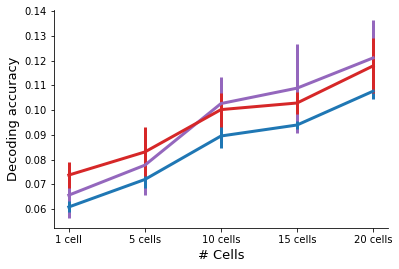

In [50]:
# decoding accuracy depending on the number of cells used in the model

load_date = '2023-10-20'
np_path = save_path / 'all conditions' / 'num_cell'
result = np.zeros((3,5,5))    # modality * rat * num_cell
#result_shuffle = np.zeros((3,5,9))    # modality * rat * timebin

for i,n in enumerate([1, 5, 10, 15, 20]):
    real_data = np.load(np_path / f'{load_date}_{100}ms_{n}cells_{100}iter_real.npy')
    #shuffle_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_shuffle.npy')
    #shuffle_mean = np.mean(shuffle_data, axis=0)
    
    for j in range(3):
        result[j,:,i] = (real_data[:,j,j]+real_data[:,j+3,j+3])/6
        #result_shuffle[i,:,t] = (shuffle_mean[:,i,i]+shuffle_mean[:,i+3,i+3])/3

mean_real = np.mean(result, axis=0)
sem_real = stats.sem(result, axis=0)
#mean_shuffle = np.mean(result_shuffle, axis=1)

fig,ax = plt.subplots(figsize=(6,4))

for i in range(3):
    ax.errorbar(range(5),mean_real[i],yerr=sem_real[i], color=color[i], linewidth=3)
    #ax.plot(mean_shuffle[i], color=color[i], linestyle='--', linewidth=2)

ax.set_xticks(range(5));
ax.set_xticklabels(['1 cell', '5 cells', '10 cells', '15 cells', '20 cells']);
#ax.set_yticks(np.arange(0.04,0.18,0.02));
#ax.set_ylim([0.04,0.16])
ax.set_xlabel('# Cells', fontsize=13);
ax.set_ylabel('Decoding accuracy', fontsize=13);

#plt.savefig(fig_path / 'svg' / 'decoding_accuracy_across_time.svg')

In [82]:
# decoding accuracy depending on the number of cells used in the model

load_date = '2023-10-20'
np_path = save_path / 'all conditions' / 'num_cell'
result = np.zeros((3,5,5))    # modality * rat * num_cell
#result_shuffle = np.zeros((3,5,9))    # modality * rat * timebin

for i,n in enumerate([1, 5, 10, 15, 20]):
    real_data = np.load(np_path / f'{load_date}_{100}ms_{n}cells_{100}iter_real.npy')
    #shuffle_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_shuffle.npy')
    #shuffle_mean = np.mean(shuffle_data, axis=0)
    
    for j in range(3):
        result[j,:,i] = (real_data[:,j,j]+real_data[:,j+3,j+3])/6
        #result_shuffle[i,:,t] = (shuffle_mean[:,i,i]+shuffle_mean[:,i+3,i+3])/3

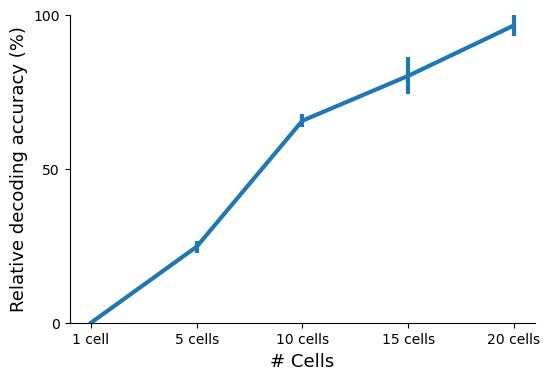

In [105]:
a = np.mean(result,axis=0)
for i in range(5):
    a[i,:] = (a[i,:]-np.min(a[i,:])) / (np.max(a[i,:])-np.min(a[i,:]))

a_mean = np.mean(a, axis=0)
a_sem = stats.sem(a, axis=0)

fig,ax = plt.subplots(figsize=(6,4))
ax.errorbar(x = range(5), y = a_mean*100, yerr = a_sem*100, linewidth=3)
ax.set_xticks(range(5))
ax.set_xticklabels(['1 cell', '5 cells', '10 cells', '15 cells', '20 cells']);
ax.set_xlabel('# Cells', fontsize=13);
ax.set_ylabel('Relative decoding accuracy (%)', fontsize=13);
ax.set_yticks(np.arange(0,110,50));
ax.set_ylim([0, 100])

#plt.savefig(fig_path / 'svg' / 'decoding_accuracy_num_cell.svg')

---

### Decoding accuracy of different time bins (ongoing)

In [ ]:
def subsample_time(df, rat, num_trial, bin_size, time_bin, shuffle):

    scaler = StandardScaler()

    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()

    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))

    for i,cell_key in enumerate(object_cell_list):

        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)

        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub
    
    X_norm = scaler.fit_transform(X)

    return X_norm

In [ ]:
def subsample_cross_val_predict(df, model, rat, kfold, num_trial, bin_size, time_bin, shuffle):
    result = np.zeros((6,6))

    X = subsample(df, rat, num_trial, bin_size, time_bin, shuffle)
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        pred = model.predict(X[test_index,:])
        for j in range(6):
            result[j,pred[j]] += 1

    return result

___

### Contribution to decoding by different cell categories
This analysis utilize permutation feature importance approach to quantify relative contribution to the decoding accuracy by different cell categories.

In [10]:
def subsample_category(df, rat, num_trial, bin_size, time_bin):
    scaler = StandardScaler()
    
    num_bin = int(90/bin_size)
    
    object_cell_list = df.loc[df['rat']==int(rat),'key'].to_numpy()

    unbiased_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='unbiased'),'key'].to_numpy()
    visual_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='visual'),'key'].to_numpy()
    auditory_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='auditory'),'key'].to_numpy()

    X_visual = np.zeros((6*num_trial, len(visual_cell_list)*time_bin))
    X_auditory = np.zeros((6*num_trial, len(auditory_cell_list)*time_bin))
    X_unbiased = np.zeros((6*num_trial, len(unbiased_cell_list)*time_bin))

    v, a, u = 0, 0, 0
    
    for i,cell_key in enumerate(object_cell_list):
    
        # load trial-by-trial firing rate data of a cell
        key = str(cell_key).zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)
        
        category = df.loc[df.key==cell_key,'Category'].values[0]
        
        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
    
            if category == 'visual':
                X_visual[num_trial*c:num_trial*(c+1), time_bin*v:time_bin*(v+1)] = FR_sub
            elif category == 'auditory':
                X_auditory[num_trial*c:num_trial*(c+1), time_bin*a:time_bin*(a+1)] = FR_sub
            elif category == 'unbiased':
                X_unbiased[num_trial*c:num_trial*(c+1), time_bin*u:time_bin*(u+1)] = FR_sub
        
        if category == 'visual':
            v += 1
        elif category == 'auditory':
            a += 1
        elif category == 'unbiased':
            u += 1
            
    X_visual_norm = scaler.fit_transform(X_visual)
    X_auditory_norm = scaler.fit_transform(X_auditory)
    X_unbiased_norm = scaler.fit_transform(X_unbiased)

    return X_visual_norm, X_auditory_norm, X_unbiased_norm

In [11]:
def permutation_feature_importance(df, model, rat, kfold, num_trial, bin_size, time_bin, same_num_cell):
    result = np.zeros((2,6,6))
    
    X_visual, X_auditory, X_unbiased = subsample_category(df, rat, num_trial, bin_size, time_bin)
    
    v_count = int(np.shape(X_visual)[1]/9)
    a_count = int(np.shape(X_auditory)[1]/9)
    u_count = int(np.shape(X_unbiased)[1]/9)
    # the number of cells to be permutated
    num_cell = min([v_count+a_count, u_count])
    
    X = np.hstack((X_visual, X_auditory, X_unbiased))
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        
        # permutation on visual & auditory cells
        X_VA = np.hstack((X_visual[test_index,:], X_auditory[test_index,:]))
        if same_num_cell:
            selected_VA = np.random.choice(int(np.shape(X_VA)[1]/9), num_cell, replace=False)
            for c in selected_VA:    # permutation on visual + auditory cells
                X_VA[:, 9*c:9*(c+1)] = np.random.permutation(X_VA[:, 9*c:9*(c+1)])
        else:
            X_VA = np.random.permutation(X_VA)
        X_VA_perm = np.hstack((X_VA, X_unbiased[test_index,:]))
        pred_VA = model.predict(X_VA_perm)

        # permutation on unbiased cells
        if same_num_cell:    # permutation on the same number of unbiased cells with visual + auditory
            selected_unbiased = np.random.choice(int(np.shape(X_unbiased)[1]/9), num_cell, replace=False)
            for c in selected_unbiased:
                X_unbiased[:, 9*c:9*(c+1)] = np.random.permutation(X_unbiased[:, 9*c:9*(c+1)])
        else:    # permuation on all unbiased cells
            X_unbiased = np.random.permutation(X_unbiased)
        X_unbiased_perm = np.hstack((X_visual[test_index,:], X_auditory[test_index,:], X_unbiased[test_index,:]))
        pred_unbiased = model.predict(X_unbiased_perm)
        
        Y_test = Y[test_index]
        
        for j in range(len(pred_VA)):
            result[0,Y_test[j],int(pred_VA[j])] += 1
            result[1,Y_test[j],int(pred_unbiased[j])] += 1

    return result

In [ ]:
%%time

perm_same = np.zeros((2,len(rat_list),6,6))
perm_all = np.zeros((2,len(rat_list),6,6))

for r,rat in enumerate(rat_list):
    loop_start = time.time()

    perm_same_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, kfold, num_trial, bin_size, 9, 1) for j in range(num_iter))   
    perm_all_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, kfold, num_trial, bin_size, 9, 0) for j in range(num_iter))   

    perm_same[:,r,:,:] = np.sum(perm_same_rat,axis=0)/(num_iter*kfold*6)
    perm_all[:,r,:,:] = np.sum(perm_all_rat,axis=0)/(num_iter*kfold*6)

    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

np_save_path = save_path / 'all conditions' / 'permutation feature importance'
os.makedirs(np_save_path, exist_ok=True)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_same.npy',perm_same)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy',perm_all)

---

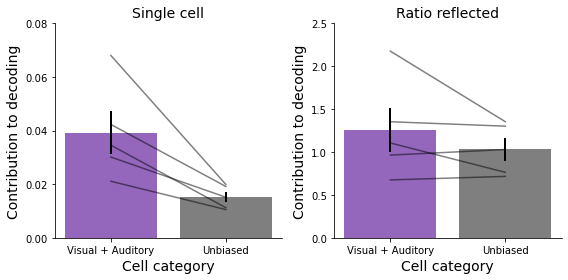

============== Paired t-test (all neurons) ==============
               T  dof alternative     p-val         CI95%  cohen-d   BF10  \
T-test  3.698926    4   two-sided  0.020855  [0.01, 0.04]  1.85171  4.149   

           power  
T-test  0.865532  

========= Paired t-test (same number of neurons) =========
              T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.33214    4   two-sided  0.253645  [-0.24, 0.69]  0.488945  0.729   

           power  
T-test  0.136521  


In [14]:
np_path = save_path / 'all conditions' / 'permutation feature importance'
load_date = '2023-08-01'

perm_all = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy')
real = np.load(save_path / 'all conditions' / '2023-07-28_100ms_9bins_100iter_real.npy')
real = real/6

num_cell = np.zeros((5,2))
perm_all_result = np.zeros((5, 2))

prop_weight = [32, 68]

for i in range(5):
    num_cell[i,0] = df2.groupby(['rat', 'Category']).size()[int(rat_list[i])]['auditory']+\
    df2.groupby(['rat', 'Category']).size()[int(rat_list[i])]['visual']
    num_cell[i,1] = df2.groupby(['rat', 'Category']).size()[int(rat_list[i])]['unbiased']
    
    real_result = np.trace(real[i,:,:])
    perm_all_result[i,0] = (real_result-np.trace(perm_all[0,i,:,:]))/(real_result+np.trace(perm_all[0,i,:,:]))
    perm_all_result[i,1] = (real_result-np.trace(perm_all[1,i,:,:]))/(real_result+np.trace(perm_all[1,i,:,:]))

fig, ax = plt.subplots(1,2, figsize=(8,4))

x = ['Visual + Auditory','Unbiased']

y1 = perm_all_result/num_cell
y2 = (perm_all_result/num_cell)*prop_weight

ax[0].bar(x,np.mean(y1, axis=0), color=['tab:purple', 'tab:gray'])
ax[0].errorbar(x, np.mean(y1, axis=0), yerr=stats.sem(y1, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[0].plot([y1[i,0], y1[i,1]], color='black', alpha=0.5)

ax[1].bar(x,np.mean(y2, axis=0), color=['tab:purple', 'tab:gray'])
ax[1].errorbar(x, np.mean(y2, axis=0), yerr=stats.sem(y2, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[1].plot([y2[i,0], y2[i,1]], color='black', alpha=0.5)

t = ['Single cell', 'Ratio reflected']
for i in range(2):
    ax[i].set_title(t[i], fontsize=14)
    ax[i].set_xlabel('Cell category', fontsize=14)
    ax[i].set_ylabel('Contribution to decoding', fontsize=14)
ax[0].set_yticks(np.arange(0, 0.09, 0.02))
ax[0].set_ylim([0, 0.08])
ax[1].set_yticks(np.arange(0, 2.6, 0.5))
ax[1].set_ylim([0, 2.5])

plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'perm_importance_bar.svg')
plt.show()

ttest_all = pg.ttest(y1[:,0], y1[:,1], paired=True)
print('============== Paired t-test (all neurons) ==============')
print(ttest_all)
print('')

ttest_same = pg.ttest(y2[:,0], y2[:,1], paired=True)
print('========= Paired t-test (same number of neurons) =========')
print(ttest_same)

---

---

### Object / modality decoding performance of different categories
Here, we verified if different object cell categories (i.e., visual, auditory, unbiased) contributed differently to the decoding performance.

#### Parameter setup

#### Real data

---